In [1]:
## Overall error mitigation parameters
numqubits = 3


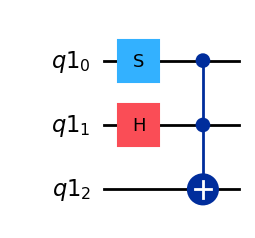

In [18]:
## Step 1: Create your original circuit. 

import qiskit
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator
from qiskit import transpile
from qiskit.visualization import plot_distribution
import numpy as np

q0 = QuantumRegister(numqubits, name = 'q0')
qc0 = QuantumCircuit(q0, name = 'qc0') # exists solely to add barriers. 

qc0.barrier()

q1 = QuantumRegister(numqubits, name='q1')
qc1 = QuantumCircuit(q1, name = 'qc1')

qc1.s(0)
qc1.h(1)
qc1.ccx(0,1,2)
#qc1.cx(0,2)

qc1.draw('mpl')


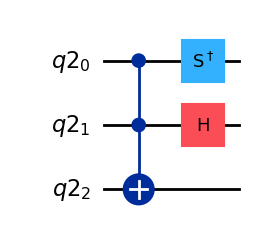

In [3]:
## Step 2: Create the inverse of that original quantum circuit

## Decompose the original circuit into layers
dag = circuit_to_dag(qc1)

# Create a reversed version of the original circuit
temp = reversed(list(dag.layers()))

## Create a blank quantum circuit that will store the inverted version of the original circuit
q2 = QuantumRegister(numqubits, name='q2')
qc2 = QuantumCircuit(q2, name = 'qc2')

# Iterate through the reversed circuit
# to insert the original circuit into the new circuit
for temp2 in temp:
    
    layer_as_circuit = dag_to_circuit(temp2['graph']).inverse()
    qc2 = qc2.compose(layer_as_circuit, [0,1,2])

qc2.draw('mpl')

In [103]:
def generate_folded_circuit(lambda_value,original_circuit, inverse_circuit, final_circuit, barrier_circuit):

    if not(isinstance(lambda_value, int)):
        print("Lambda_value is not an integer. Please enter an integer. ")
        return final_circuit;
    if not(lambda_value % 2):
        print("Lambda_value is not an odd integer. Please enter an odd integer. ")
        return final_circuit;
    if lambda_value == 1:
        final_circuit = final_circuit.compose(original_circuit); # The "folded" circuit is just the original.
        final_circuit.measure_all(); # We assume that the final_circuit object is empty. 
        return final_circuit;
    print("OK value of lambda")
    
    final_circuit = final_circuit.compose(original_circuit) # Original circuit. 
    
    ## Repeat the original & inverse circuit pairs for lambda
    print((lambda_value-1)/2)
    for index in range(round((lambda_value-1)/2)):
        final_circuit = final_circuit.compose(barrier_circuit)
        final_circuit = final_circuit.compose(inverse_circuit)
        final_circuit = final_circuit.compose(barrier_circuit)
        final_circuit = final_circuit.compose(original_circuit)
    
    final_circuit.measure_all()
    return final_circuit;

      ┌───┐     
q1_0: ┤ S ├──■──
      ├───┤  │  
q1_1: ┤ H ├──■──
      └───┘┌─┴─┐
q1_2: ─────┤ X ├
           └───┘
OK value of lambda
1.0


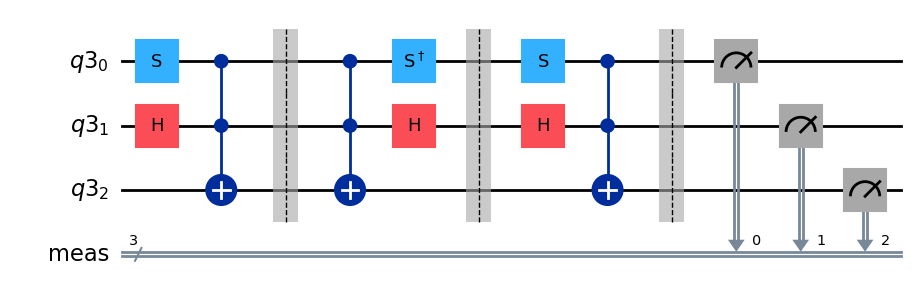

In [5]:
q3 = QuantumRegister(numqubits, name='q3')
qc3 = QuantumCircuit(q3, name = 'qc3')
qc3 = generate_folded_circuit(3, qc1, qc2, qc3, qc0)
qc3.draw('mpl')

In [6]:
q_ideal = QuantumRegister(numqubits, name = 'q_ideal')
qc_ideal = QuantumCircuit(q_ideal, name = 'q_ideal')
qc_ideal = qc1.copy()
qc_ideal.measure_all()
print(qc_ideal)
print(qc1)

        ┌───┐      ░ ┌─┐      
  q1_0: ┤ S ├──■───░─┤M├──────
        ├───┤  │   ░ └╥┘┌─┐   
  q1_1: ┤ H ├──■───░──╫─┤M├───
        └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
  q1_2: ─────┤ X ├─░──╫──╫─┤M├
             └───┘ ░  ║  ║ └╥┘
meas: 3/══════════════╩══╩══╩═
                      0  1  2 
      ┌───┐     
q1_0: ┤ S ├──■──
      ├───┤  │  
q1_1: ┤ H ├──■──
      └───┘┌─┴─┐
q1_2: ─────┤ X ├
           └───┘


In [7]:
## Overall simulation parameters
numshots = 10000
target_value = ""
for index in range(numqubits):
    target_value += "0"
print(target_value)

000


In [11]:
# Construct an ideal simulator
sim_ideal = AerSimulator(method='density_matrix')


# Perform an ideal simulation
result = sim_ideal.run(transpile(qc_ideal, sim_ideal), shots = numshots).result()
counts = result.get_counts(0)
plot_distribution(counts, title='Ideal counts for my circuit')

ideal_val = result.get_counts(0)[target_value]
print(ideal_val/numshots)

0.4925


In [96]:
## Create a simple depolarising noise model
# All gates suffer from depolarising noise uniformly
noise_model = NoiseModel()

depolarising_prob = 0.01;

# Add depolarizing error to all single qubit gates
error = depolarizing_error(depolarising_prob, 1)
cx_error = depolarizing_error(depolarising_prob, 2) # CNOT errors
ccx_error = depolarizing_error(depolarising_prob, 3) # CCNOT errors

noise_model.add_all_qubit_quantum_error(
    error, ["h"]
)
noise_model.add_all_qubit_quantum_error(
    error, ["z"]
)
noise_model.add_all_qubit_quantum_error(
    error, ["s"]
)
noise_model.add_all_qubit_quantum_error(
    cx_error, ["cx"]
)
noise_model.add_all_qubit_quantum_error(
    ccx_error, ["ccx"]
)

In [16]:
# Perform a noisy simulation
sim_noisy = AerSimulator(noise_model=noise_model, method='density_matrix')

result = sim_noisy.run(transpile(qc3, sim_noisy), shots = numshots).result()
counts = result.get_counts(0)
plot_distribution(counts, title='Noisy counts for my circuit')
noisy_val = result.get_counts(0)[target_value]
print(noisy_val/numshots)

0.3688


In [97]:
## Perform a series of at least 2 noisy simulations. 
lambda_value_array = [1, 3,5];
measured_values_array = [];
#measured_values_array.append(ideal_val/numshots)


for value in lambda_value_array:
    q3 = QuantumRegister(numqubits, name='q3')
    qc3 = QuantumCircuit(q3, name = 'qc3')
    qc3 = generate_folded_circuit(value, qc1, qc2, qc3, qc0)
    
    # Perform a noisy simulation
    sim_noisy = AerSimulator(noise_model=noise_model, method='density_matrix')
    
    result = sim_noisy.run(transpile(qc3, sim_noisy), shots = numshots).result()
    counts = result.get_counts(0)
    #plot_distribution(counts, title='Noisy counts for my circuit')
    noisy_val = result.get_counts(0)[target_value]
    print(noisy_val/numshots)
    measured_values_array.append(noisy_val/numshots)
    

      ┌───┐     
q1_0: ┤ S ├──■──
      ├───┤  │  
q1_1: ┤ H ├──■──
      └───┘┌─┴─┐
q1_2: ─────┤ X ├
           └───┘
lambda = 1
0.4918
      ┌───┐     
q1_0: ┤ S ├──■──
      ├───┤  │  
q1_1: ┤ H ├──■──
      └───┘┌─┴─┐
q1_2: ─────┤ X ├
           └───┘
OK value of lambda
1.0
0.4838
      ┌───┐     
q1_0: ┤ S ├──■──
      ├───┤  │  
q1_1: ┤ H ├──■──
      └───┘┌─┴─┐
q1_2: ─────┤ X ├
           └───┘
OK value of lambda
2.0
0.4837


In [98]:
measured_values_array

[0.4918, 0.4838, 0.4837]

In [99]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a + b * np.exp(-c * x)
    

In [100]:
## Data processing part

lambda_vals_tot = np.array(lambda_value_array)
measured_vals_tot = np.array(measured_values_array)

# Interrogation domain
xp = np.linspace(0,np.amax(lambda_vals_tot),100)

# Polynomial fit
linfit = np.polyfit(lambda_vals_tot, measured_vals_tot, 1)
p_p = np.poly1d(linfit)
error_mitigated_value_polynomial = p_p(0)

# Richardson extrapolation fit
REfit = np.polyfit(lambda_vals_tot, measured_vals_tot, len(measured_vals_tot)-1)
p_RE = np.poly1d(REfit)
error_mitigated_value_RE = p_RE(0)

# Exponential fit
popt, pcov = curve_fit(func, lambda_vals_tot, measured_vals_tot)
error_mitigated_value_exp = func(0, *popt)
print(popt)

[0.48369873 0.07245992 2.19101332]


C:\Users\DavidRen\AppData\Local\Temp\ipykernel_15396\1311931050.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, lambda_vals_tot, measured_vals_tot)


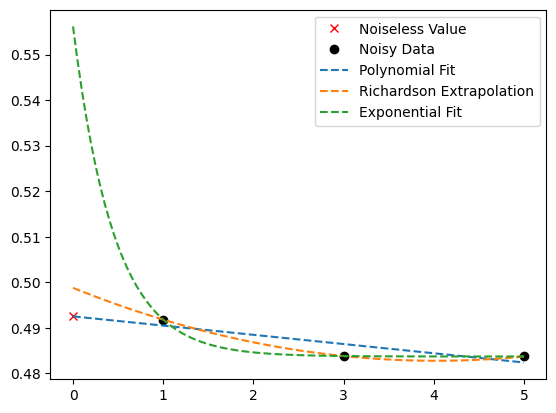

In [101]:

plt.figure()
plt.plot([0], ideal_val/numshots, 'rx', label="Noiseless Value") # Ideal value, without noise. 
plt.plot(lambda_vals_tot, measured_vals_tot, 'ko', label="Noisy Data")
plt.plot(xp, p_p(xp), '--', label="Polynomial Fit")
plt.plot(xp, p_RE(xp), '--', label="Richardson Extrapolation")
plt.plot(xp, func(xp, *popt), '--', label="Exponential Fit") # Exponential fit
plt.legend()

#plt.plot([0],ideal_val/numshots, 'x', lambda_vals_tot, measured_vals_tot, '.', xp, p(xp), '--')

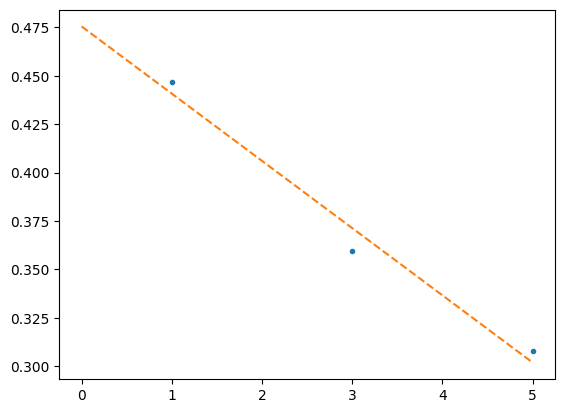

In [89]:
plt.plot(lambda_vals_tot, measured_vals_tot, '.', xp, p(xp), '--')

In [36]:
print(np.array([1,lambda_value_array]))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

TypeError: unsupported operand type(s) for +: 'int' and 'list'

In [191]:
d = 2;
lam_goal = 6;

k = int(proper_round(d*(lam_goal-1)/2))

n = k//d
s = k%d

print(n)
print(s)

2
1


In [156]:
def proper_round(num, dec=0):
    num = str(num)[:str(num).index('.')+dec+2]
    if num[-1]>='5':
      a = num[:-2-(not dec)]       # integer part
      b = int(num[-2-(not dec)])+1 # decimal part
      return float(a)+b**(-dec+1) if a and b == 10 else float(a+str(b))
    return float(num[:-1])

In [192]:
print('hello')

hello


In [193]:
pip list

Package                   VersionNote: you may need to restart the kernel to use updated packages.

------------------------- --------------
annotated-types           0.6.0
anyio                     4.3.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     23.2.0
Babel                     2.14.0
beautifulsoup4            4.12.3
bleach                    6.1.0
Bottleneck                1.3.7
certifi                   2024.2.2
cffi                      1.16.0
charset-normalizer        3.3.2
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.2.0
cryptography              42.0.5
cycler                    0.12.1
debugpy                   1.8.1
decorator                 5.1.1
defusedxml                0.7.1
dill                      0.3.8
executing                 2.0.1
fastjsonschema            2.19.1
fonttools      

In [196]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

ModuleNotFoundError: No module named 'qiskit.tools'

In [203]:
import qiskit
import qiskit.tools.jupyter
%qiskit_version_table

ModuleNotFoundError: No module named 'qiskit.tools'